# Title: Detecting Melanoma: A CNN Approach

## Introduction
The objective of this project is to develop a convolutional neural network (CNN) model capable of accurately identifying melanoma, a potentially lethal form of skin cancer. Melanoma represents a significant health concern, responsible for a staggering 75% of skin cancer-related fatalities. An automated solution capable of analyzing images and promptly alerting dermatologists to the presence of melanoma holds immense promise in streamlining diagnostic processes and reducing the manual workload associated with diagnosis.

## Dataset Overview
The dataset comprises 2,357 images depicting both malignant and benign oncological conditions. These images were sourced from the International Skin Imaging Collaboration (ISIC). Each image was meticulously categorized based on ISIC's classification system, ensuring a balanced representation of various skin conditions. Notably, melanomas and moles are slightly overrepresented in the dataset.

Included Diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

## Key Steps in the Project
1. Data Reading and Understanding
2. Dataset Creation
3. Dataset Visualization
4. Model Building and Training
5. Data Augmentation
6. Model Refinement and Training with Augmented Data
7. Class Distribution Analysis
8. Addressing Class Imbalances
9. Model Refinement and Training on Balanced Data
10. Conclusion

By meticulously following these steps, we aim to develop a robust CNN model capable of effectively detecting melanoma while addressing potential challenges such as class imbalances within the dataset.


In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

## Data Reading/Data Understanding

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/SkinDiseaseImages/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/SkinDiseaseImages/Test")

In [4]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Dataset creation
Using batch size of 32 and resizing images to 180 x 180.

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.


In [6]:
# Using seed=123 while creating training dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size 180 x 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Using seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size 180 x 180
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Storing List of all the classes of skin cancer from the class names in the class_names attribute on datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Number of classes: ", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes:  9


## Dataset visualisation


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The tensor image_batch represents a batch of 32 images, each with dimensions 180x180 pixels and 3 color channels (RGB). Similarly, the tensor label_batch contains corresponding labels for the 32 images, forming a shape of (32,).

## Visualize one instance of all the nine classes present in the dataset


Found 2239 files belonging to 9 classes.


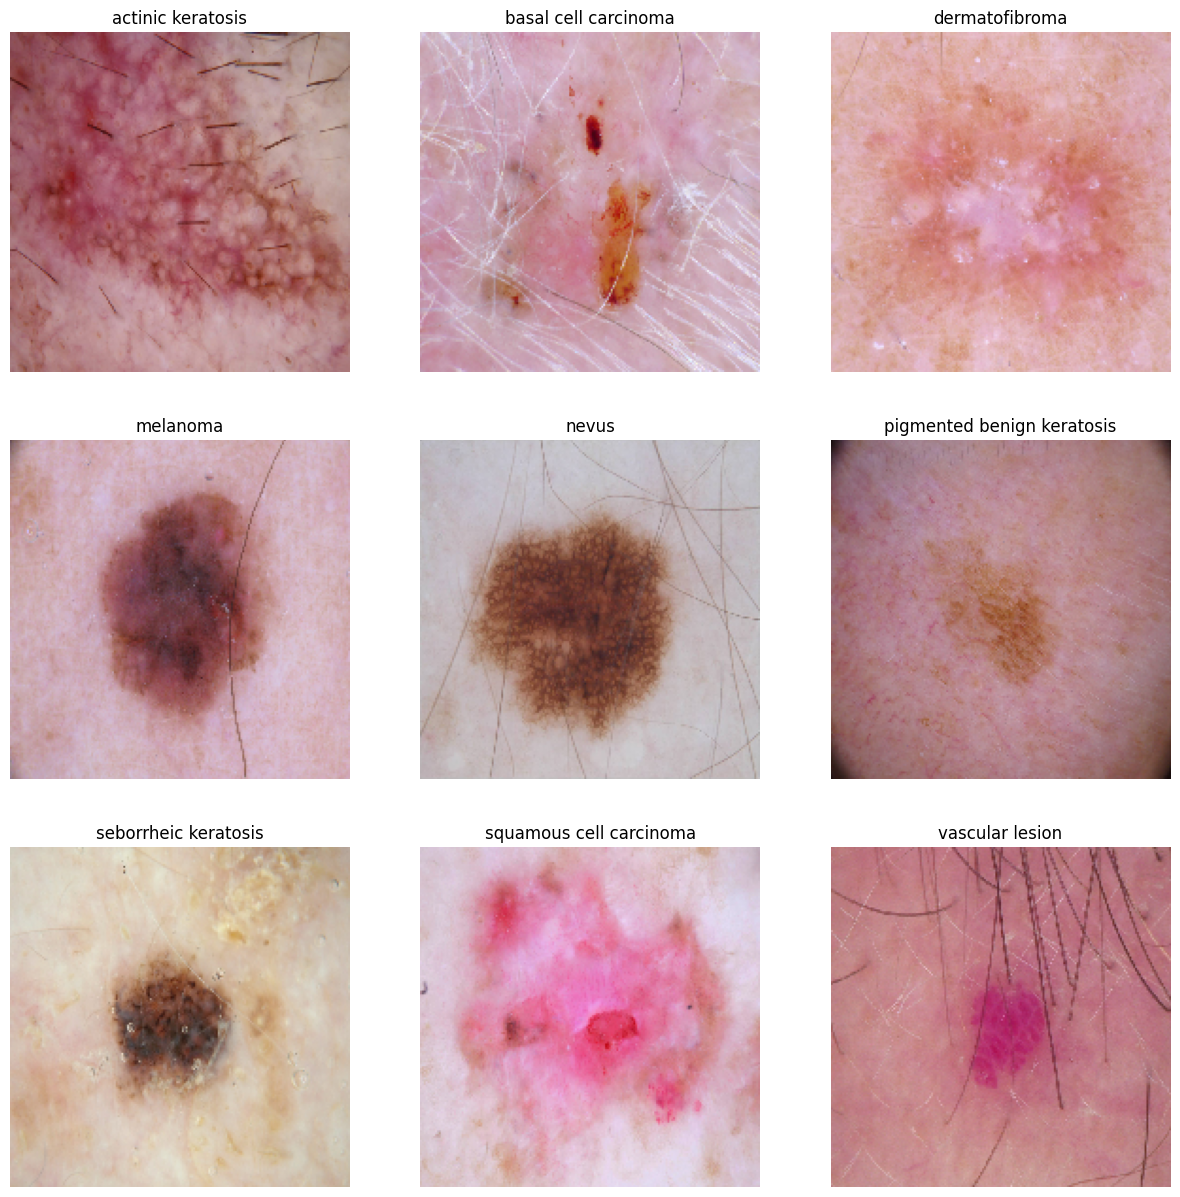

In [10]:
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

## Model Building & training
Using layers.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. It is good to standardize values to be in the [0, 1]

In [11]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#model creation
model = Sequential([

    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescaling layer

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),
    #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting

    layers.Flatten(),
    #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector

    layers.Dense(128, activation='relu'),
    #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.

    layers.Dense(num_classes)# output dense layer
])

In [13]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

## Train the model

In [15]:
# training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 348ms/step - loss: 2.0003 - accuracy: 0.2478 - val_loss: 1.7626 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 14s 254ms/step - loss: 1.5959 - accuracy: 0.4414 - val_loss: 1.5209 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 14s 253ms/step - loss: 1.4233 - accuracy: 0.5117 - val_loss: 1.4287 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 14s 253ms/step - loss: 1.3568 - accuracy: 0.5279 - val_loss: 1.4221 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 14s 252ms/step - loss: 1.2823 - accuracy: 0.5519 - val_loss: 1.3759 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 14s 252ms/step - loss: 1.1464 - accuracy: 0.5999 - val_loss: 1.4731 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 14s 252ms/step - loss: 1.0894 - accuracy: 0.6183 - val_loss: 1.3955 - val_accuracy: 0.5436

## Visualizing the results

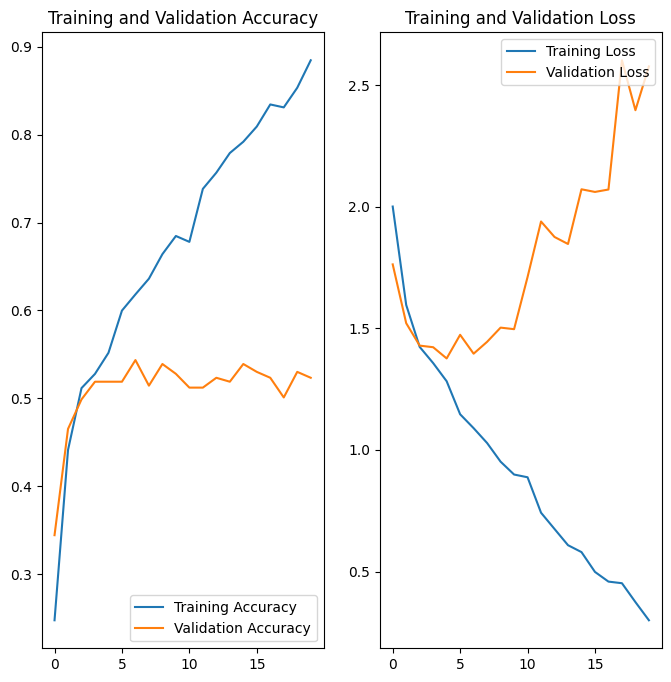

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Based on the above plot and statistics, there is evidence of overfitting in the model.

Here's why:

### High Training Accuracy, Low Validation Accuracy:
This indicates that your model is performing well on the data it was trained on (training set), but it doesn't generalize well to unseen data (validation set). High training accuracy suggests that the model has learned to fit the training data very closely, but if the validation accuracy is low, it suggests that the model is not able to generalize its predictions to new, unseen data.

### Low Training Loss, High Validation Loss:
Similarly, low training loss indicates that the model is fitting the training data well, while high validation loss indicates that it performs poorly on unseen data. This is a classic sign of overfitting: the model is too complex and has learned to fit the noise in the training data rather than capturing the underlying patterns that would generalize to new data.

In summary, the model is overfitting, as it's performing well on the training data but poorly on the validation data. To address overfitting, we can try techniques such as:

Adding more training data. Using regularization techniques like dropout or L2 regularization. Simplifying the model architecture. Early stopping during training. Data augmentation techniques. Cross-validation to tune hyperparameters more effectively.

## Data Augmentation

In [17]:
# Choosing the following strategy for data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.1,
                      input_shape=(img_height,
                                   img_width,
                                   3))
  ]
)

visualizing how augmentation strategy works for one instance of training image.


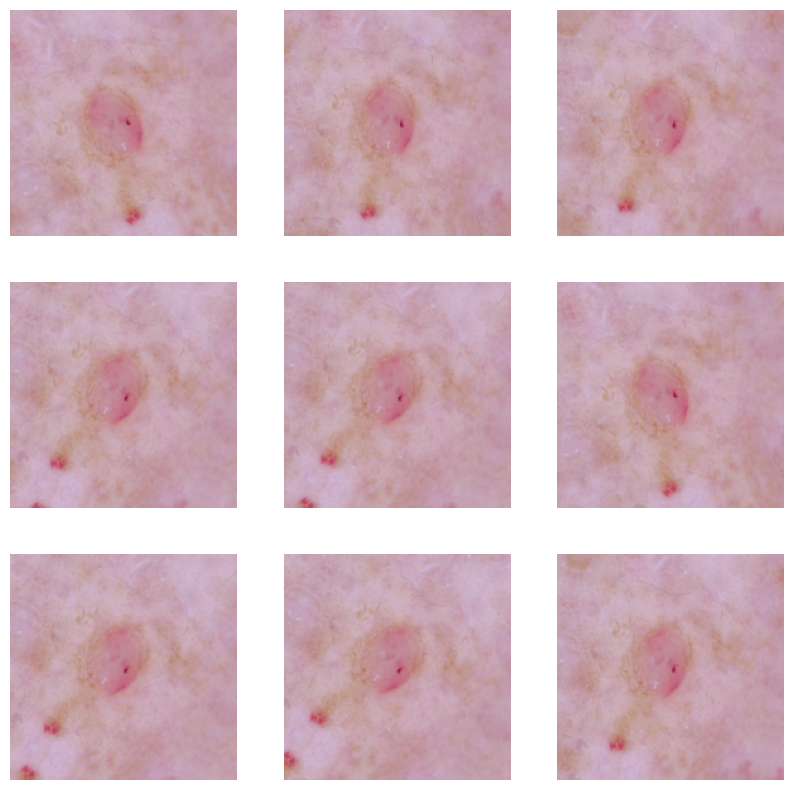

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Building & Training the Model on the augmented data

In [19]:
#Dataset.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# Adding data_augmentation layer and adding 2 dropout layers for reducing overfitting
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [21]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

## Train the Model

In [23]:
## training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 264ms/step - loss: 2.0499 - accuracy: 0.2333 - val_loss: 1.8769 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 15s 261ms/step - loss: 1.8235 - accuracy: 0.3544 - val_loss: 1.6831 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 15s 265ms/step - loss: 1.7150 - accuracy: 0.3873 - val_loss: 1.5550 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 15s 263ms/step - loss: 1.6360 - accuracy: 0.4353 - val_loss: 1.4833 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 15s 266ms/step - loss: 1.5747 - accuracy: 0.4598 - val_loss: 1.4911 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 15s 266ms/step - loss: 1.4987 - accuracy: 0.4665 - val_loss: 1.4607 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 15s 263ms/step - loss: 1.4858 - accuracy: 0.4838 - val_loss: 1.4595 - val_accuracy: 0.5257

## Visualizing the results


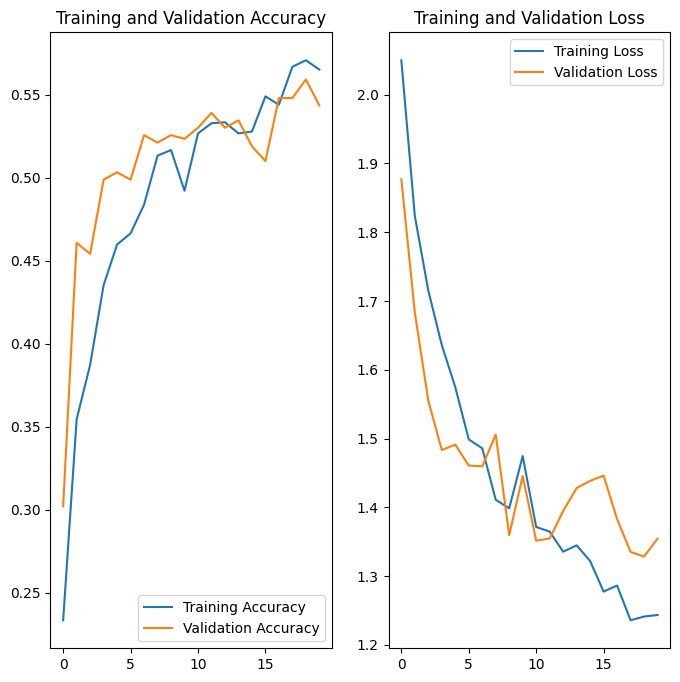

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although the gap between training and validation accuracies has decreased, both still appear to be low, indicating potential underfitting. This suggests that the model may have difficulty capturing even basic patterns in the dataset, possibly due to the limited size of the training data. To delve deeper into this issue, let's analyze the distribution of classes within the dataset to check for any signs of class imbalance.






## Class distribution
Visualizing distribution of classes in the training dataset.


In [25]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [26]:
import plotly.express as px

fig = px.bar(df, x='No. of Image', y='Class', orientation='h', title='Distribution of Classes')
fig.update_layout(
    yaxis=dict(autorange="reversed"),  # Reverse y-axis to display classes from top to bottom
    xaxis_title='No. of Image',
    yaxis_title='Class',
    title_x=0.5,
    title_y=0.95,
    title_font_size=20,
    width=800,
    height=600
)
fig.show()

In [27]:
sample_counts = df['No. of Image']
# Calculate the total number of samples
total_samples = sum(sample_counts)

# Calculate the percentage of samples for each class
class_percentages = [count / total_samples * 100 for count in sample_counts]

# Print the class names with their respective percentages
for class_name, percentage in zip(class_names, class_percentages):
    print(f"{class_name}: {percentage:.2f}%")

actinic keratosis: 5.09%
basal cell carcinoma: 16.79%
dermatofibroma: 4.24%
melanoma: 19.56%
nevus: 15.94%
pigmented benign keratosis: 20.63%
seborrheic keratosis: 3.44%
squamous cell carcinoma: 8.08%
vascular lesion: 6.21%


**Which class has the least number of samples?**
<br>seborrheic keratosis has 77 samples, which is the least number of samples among all the classes

<br><br>
**Which classes dominate the data in terms proportionate number of samples?**
<br>The classes with the highest proportions are:
<br>Squamous Cell Carcinoma: 20.63%
<br>Melanoma: 19.56%
<br>Pigmented Benign Keratosis: 16.79%
<br>Vascular Lesion: 15.94%
These classes have the highest percentages, indicating that they dominate the dataset in terms of the proportionate number of samples.


## Handling class imbalances


In [28]:
#install Augmentor
!pip install Augmentor

In [29]:
import Augmentor
path_to_training_dataset=str(data_dir_train)+"/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7BC3FEAD0>: 100%|██████████| 500/500 [00:04<00:00, 119.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7BC44CC70>: 100%|██████████| 500/500 [00:04<00:00, 123.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7BC47EE60>: 100%|██████████| 500/500 [00:04<00:00, 119.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA7BC44FF40>: 100%|██████████| 500/500 [00:05<00:00, 86.53 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=964x672 at 0x7FA7BC5C3AC0>: 100%|██████████| 500/500 [00:05<00:00, 90.75 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7BC4EFA30>: 100%|██████████| 500/500 [00:04<00:00, 117.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB09C1D1960>: 100%|██████████| 500/500 [00:04<00:00, 105.28 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8EC4719F0>: 100%|██████████| 500/500 [00:04<00:00, 118.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/SkinDiseaseImages/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA904598E80>: 100%|██████████| 500/500 [00:04<00:00, 124.59 Samples/s]


In [30]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Model Building & training on the rectified class imbalance data


In [31]:
# creating train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [32]:
# creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
# removing data_augmentation layer and using remaining layers
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [35]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

## Training model


In [37]:
# using 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 56s 270ms/step - loss: 2.0801 - accuracy: 0.2020 - val_loss: 1.7005 - val_accuracy: 0.3356
Epoch 2/20
169/169 [==============================] - 43s 253ms/step - loss: 1.6760 - accuracy: 0.3722 - val_loss: 1.5207 - val_accuracy: 0.4150
Epoch 3/20
169/169 [==============================] - 43s 254ms/step - loss: 1.4736 - accuracy: 0.4429 - val_loss: 1.3387 - val_accuracy: 0.4967
Epoch 4/20
169/169 [==============================] - 43s 256ms/step - loss: 1.3778 - accuracy: 0.4881 - val_loss: 1.2484 - val_accuracy: 0.5523
Epoch 5/20
169/169 [==============================] - 43s 257ms/step - loss: 1.2722 - accuracy: 0.5306 - val_loss: 1.1316 - val_accuracy: 0.5850
Epoch 6/20
169/169 [==============================] - 44s 258ms/step - loss: 1.1908 - accuracy: 0.5582 - val_loss: 1.0728 - val_accuracy: 0.6273
Epoch 7/20
169/169 [==============================] - 43s 257ms/step - loss: 1.1165 - accuracy: 0.5838 - val_loss: 0.9695 - val_ac

## Visualising Results


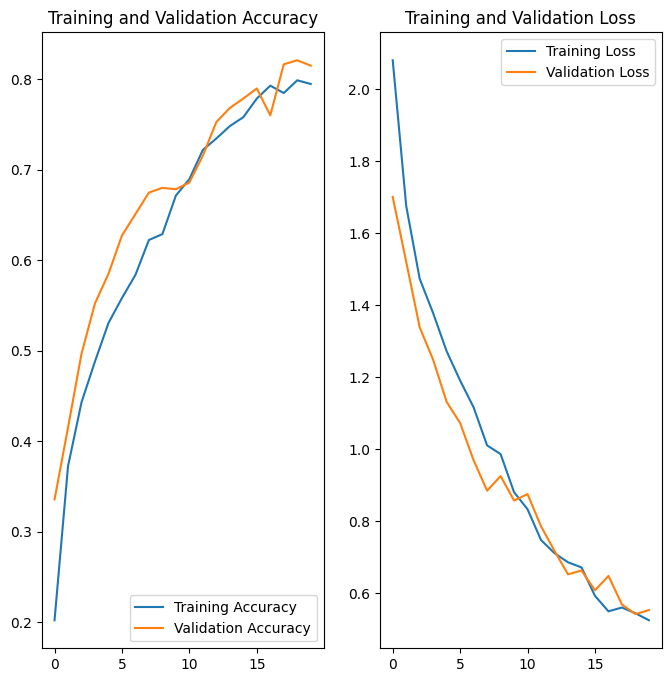

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')

plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusion
By increasing number of image samples in each class (to rebalance the dataset) the model accuracies have now increased and we could get rid of underfitting also. <br>
Data augmentation, class imbalance handling and adding dropout layers have greatly improved model performance.

## Model Prediction


1/1 [==============================] - 0s 113ms/step
Actual Class Name : melanoma
Predictive Class Name : melanoma


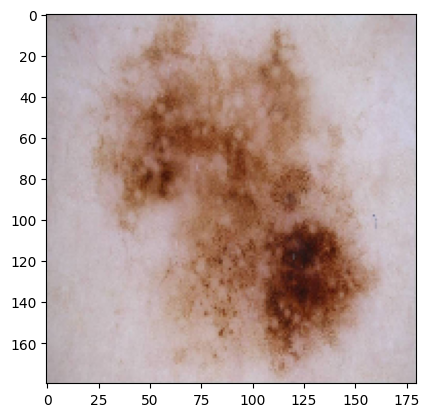

In [39]:
from glob import glob
test_image_path = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-3],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class Name : "+ class_names[3] +'\n'+ "Predictive Class Name : "+pred_class )